In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

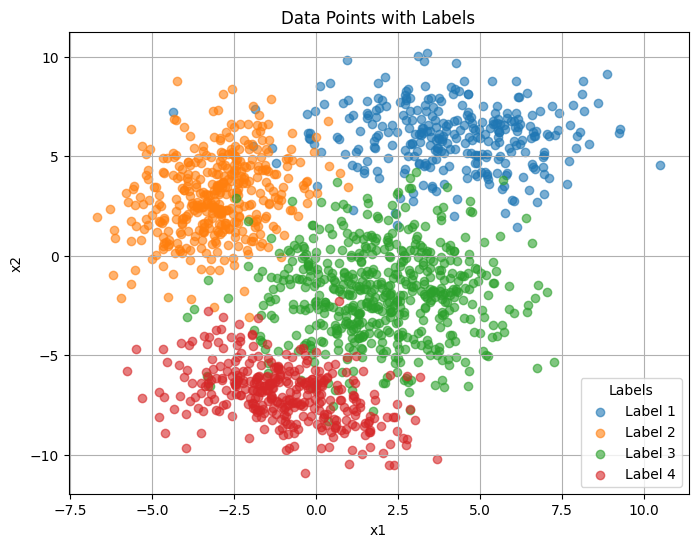

In [29]:
df = pd.read_csv('HW11-ClusteringData.csv', header=None, names=['x1', 'x2', 'label'])
plt.figure(figsize=(8, 6))
for label in df['label'].unique():
    subset = df[df['label'] == label]
    plt.scatter(subset['x1'], subset['x2'], label=f"Label {label}", alpha=0.6)
plt.title("Data Points with Labels")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(title="Labels")
plt.grid(True)
# plt.show()
plt.savefig('q1a.png', dpi=600)

In [30]:
def EuclideanDistance(v, axis):
    return np.linalg.norm(v, axis=axis)
def ManhattanDistance(v, axis):
    return np.sum(np.abs(v), axis=axis)
def AvgSilhouetteScore(data, labels, distance):
    AvgS = 0
    unique_labels = np.unique(labels)
    for i in range(len(labels)):
        cur_sample = data[i]
        cur_label = labels[i]

        same_cluster = data[labels == cur_label]
        a = np.mean([distance(cur_sample - sample, axis=0) for sample in same_cluster \
                     if not np.array_equal(cur_sample, sample)])

        b = np.inf
        for label in unique_labels:
            if label != cur_label:
                other_cluster = data[labels == label]
                b = min(b, np.mean([distance(cur_sample - sample, axis=0) for sample in other_cluster]))
        
        AvgS += (b - a) / max(a, b)
    return AvgS / len(labels)

In [31]:
class Kmeans:
    def __init__(self, k, distance, max_iters=10000, tol=1e-4):
        self.k = k
        self.distance = distance
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
    
    def _init_centroids(self, data):
        indices = np.random.choice(data.shape[0], self.k, replace=False)
        return data[indices]
    
    def _assign_clusters(self, data):
        distances = self.distance(data[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)
    
    def _updata_centroids(self, data, labels):
        return np.array([data[labels == i].mean(axis=0) for i in range(self.k)])
    
    def fit(self, data):
        self.centroids = self._init_centroids(data)
        for i in range(self.max_iters):
            labels = self._assign_clusters(data)
            new_centroids = self._updata_centroids(data, labels)
            if np.all(self.distance(new_centroids - self.centroids, axis=1) < self.tol):
                break
            self.centroids = new_centroids

    def predict(self, data):
        return self._assign_clusters(data)

In [32]:
data = df.iloc[:, :2].to_numpy()
K = [i for i in range(2, 8, 1)]
AvgSScore_Euc = []
for i in K:
    model = Kmeans(i, EuclideanDistance)
    model.fit(data)
    labels = model.predict(data)
    AvgSScore_Euc.append(float(AvgSilhouetteScore(data, labels, EuclideanDistance)))

KeyboardInterrupt: 

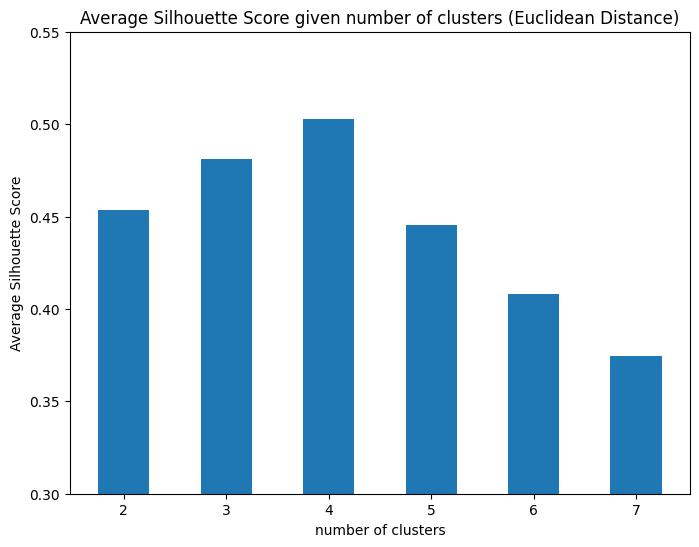

In [103]:
plt.figure(figsize=(8, 6))
plt.bar(K, AvgSScore_Euc, width=0.5)
plt.title('Average Silhouette Score given number of clusters (Euclidean Distance)')
plt.xlabel('number of clusters')
plt.ylabel('Average Silhouette Score')
plt.ylim(0.3, 0.55)
# plt.show()
plt.savefig('q1b.png', dpi=600)

In [104]:
AvgSScore_Man = []
for i in K:
    model = Kmeans(i, EuclideanDistance)
    model.fit(data)
    labels = model.predict(data)
    AvgSScore_Man.append(float(AvgSilhouetteScore(data, labels, ManhattanDistance)))

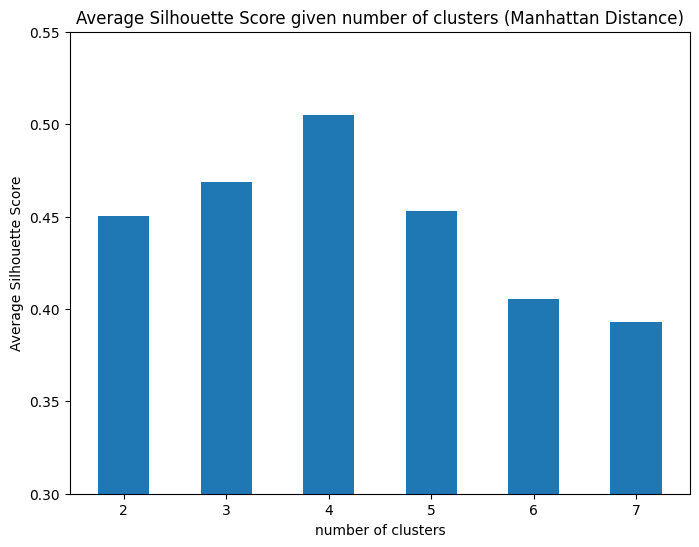

In [105]:
plt.figure(figsize=(8, 6))
plt.bar(K, AvgSScore_Man, width=0.5)
plt.title('Average Silhouette Score given number of clusters (Manhattan Distance)')
plt.xlabel('number of clusters')
plt.ylabel('Average Silhouette Score')
plt.ylim(0.3, 0.55)
# plt.show()
plt.savefig('q1c.png', dpi=600)

In [ ]:
from scipy.stats import multivariate_normal
class EM:
    def __init__(self, k, max_iter=1000, tol=1e-3):
        self.k = k
        self.max_iter=max_iter
        self.tol = tol
        self.weight = None
        self.mean = None
        self.covariances = None

    def _init_parameters(self, data):
        self.weight = np.ones(self.k) / self.k
        indices = np.random.choice(data.shape[0], self.k, replace=False)
        self.mean = data[indices]
        self.covariances = [np.eye(data.shape[1]) for _ in range(self.k)]
        # print(self.weight, self.mean, self.covariances)
        
    def fit(self, data):
        self._init_parameters(data) 
        for _ in range(self.max_iter):
            pre_likelihood = self.log_Marginallikelihood(data)
            post_prob = self.e_step(data)
            self.m_step(data, post_prob)
            log_likelihood = self.log_Marginallikelihood(data)
            if np.abs(log_likelihood - pre_likelihood) < self.tol:
                break
            

    def log_Marginallikelihood(self, data):
        log_marginallikelihood = 0 
        for k in range(self.k):
            log_marginallikelihood += np.log(self.weight[k] * multivariate_normal(self.mean[k], self.covariances[k]).pdf(data).sum())
        return log_marginallikelihood

    def e_step(self, data):
        post_prob = np.zeros((data.shape[0], self.k))
        for k in range(self.k):
            post_prob[:, k] = self.weight[k] * multivariate_normal(self.mean[k], self.covariances[k]).pdf(data)
        post_prob /= post_prob.sum(axis=1, keepdims=True)
        return post_prob
    
    def m_step(self, data, post_prob):
        self.weight = post_prob.sum(axis=0) / data.shape[0]
        self.mean = np.dot(post_prob.T, data) / post_prob.sum(axis=0)[:, np.newaxis]
        data_centered = data[:, np.newaxis, :] - self.mean
        post_prob_extended = post_prob[:, :, np.newaxis]  # Shape: (n_samples, n_components, 1)
        self.covariances = np.einsum(
            'ijk,ijl->jkl', data_centered * post_prob_extended, data_centered
        ) / post_prob.sum(axis=0)[:, np.newaxis, np.newaxis]


In [128]:
# Define the function to plot GMM distributions
def plot_gmm(data, means, covariances, weights, k):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    pos = np.dstack((x, y))

    # Compute the overall probability density function (pdf)
    total_pdf = np.zeros_like(x)
    for mean, cov, weight in zip(means, covariances, weights):
        rv = multivariate_normal(mean=mean, cov=cov)
        total_pdf += weight * rv.pdf(pos)

    # Plot the contour of the GMM
    plt.figure(figsize=(8, 6))
    plt.contour(x, y, total_pdf, levels=15, cmap="viridis")
    for label in df['label'].unique():
        subset = df[df['label'] == label]
        plt.scatter(subset['x1'], subset['x2'], label=f"Label {label}", alpha=0.6)
    plt.scatter(means[:, 0], means[:, 1], c="red", s=100, marker="x", label="Means")
    plt.title(f"{k} Gaussian Mixture Model (Contour Plot)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    # plt.show()
    plt.savefig(f'qc{k}.png', dpi=600)

1 Gaussian has weight [1.], mean [[ 0.487239   -0.31368064]]
-------------------------------------------------------------
2 Gaussian has weight [0.45573887 0.54426113], mean [[ 0.07674448  4.14786009]
 [ 0.83096796 -4.0495667 ]]
-------------------------------------------------------------
3 Gaussian has weight [0.24776738 0.52700064 0.22523198], mean [[-3.01428079  3.07826986]
 [ 0.68580732 -4.2057353 ]
 [ 3.87448791  5.06166878]]
-------------------------------------------------------------
4 Gaussian has weight [0.24928593 0.23223658 0.18818314 0.33029435], mean [[-3.01962034  3.02734944]
 [-0.91764389 -6.84225433]
 [ 4.18756722  5.92714792]
 [ 2.0135639  -1.80058744]]
-------------------------------------------------------------


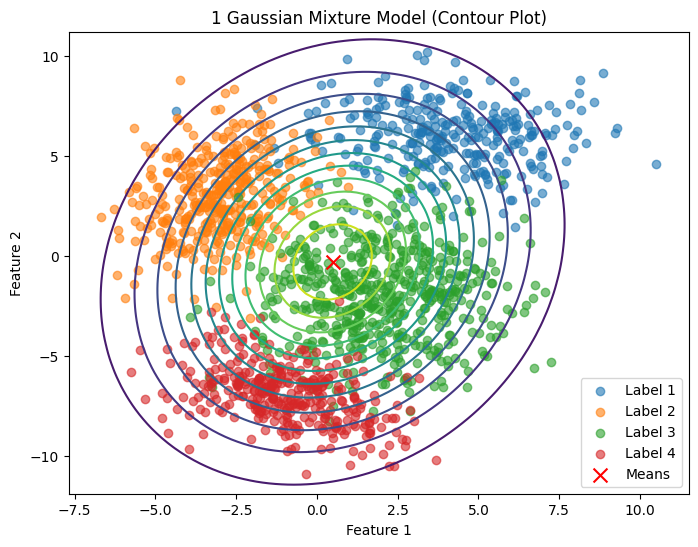

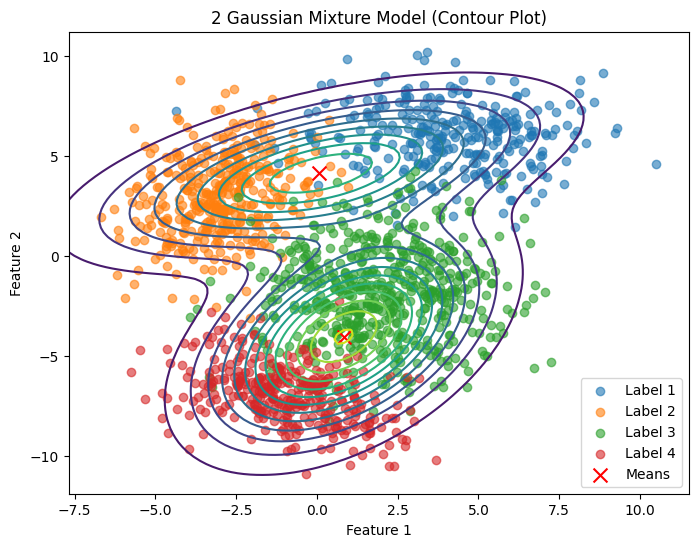

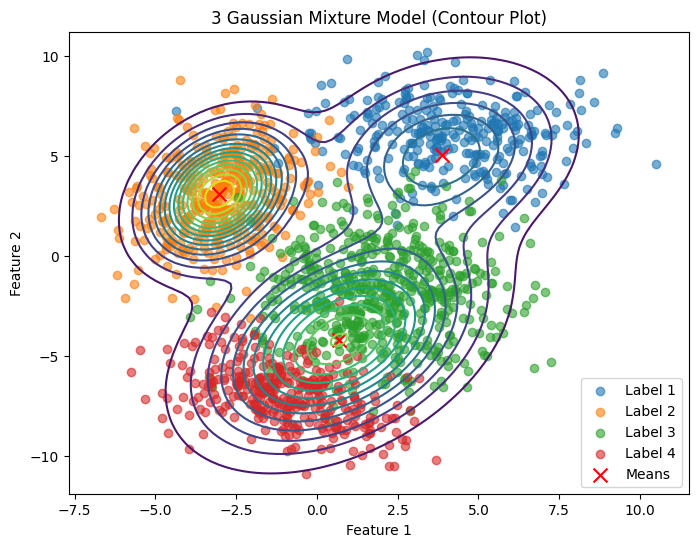

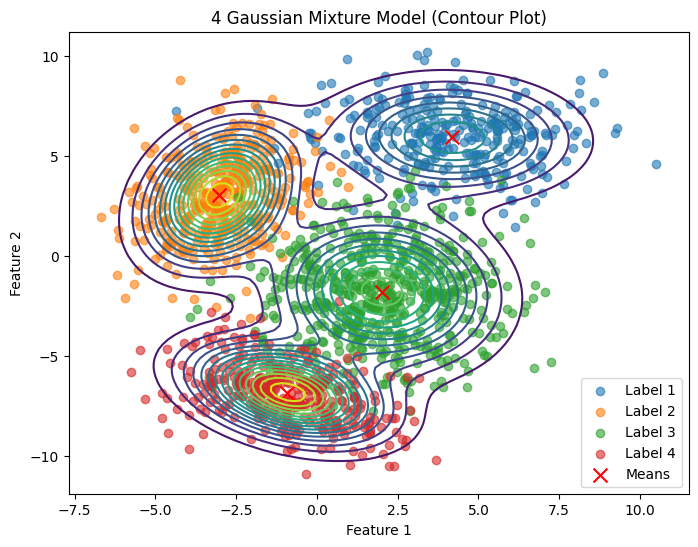

In [132]:
k = [1, 2, 3, 4]
for i in k:
    np.random.seed(42)
    model = EM(i)
    model.fit(data)
    print(f'{i} Gaussian has weight {model.weight}, mean {model.mean}')
    print('-------------------------------------------------------------')
    plot_gmm(data, model.mean, model.covariances, model.weight, i)